# Introduction to Autoencoders

This notebook is based on the [Kaggle notebook by Simon Crase](https://www.kaggle.com/code/weka511/autoencoder-implementation-in-pytorch).

An autoencoder is a neural network which is trained to reproduce its input. As the figure shows, the layers are successively shorter, until they reach a minimum, then they increase again. Data flows from left to right, and we train so the rightmost layer matches the leftmost, as closely as possible. *If we can make this work,* then the middle layer or "bottleneck" layer (labelled Feature) must somehow contain essentially the same information as the two outermost layers: we call the middle layer the *encoding*: it divides the network into two parts, the *encoder*, on the left, and the *decoder* on the right.

![Autoencoder schematic](https://www.mdpi.com/IoT/IoT-04-00016/article_deploy/html/images/IoT-04-00016-g001.png)

The loss function in this case is the identity function: $MSE = \sum (x_i - \hat{x_i})^2$

The [manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis) asserts that many high-dimensional data sets that occur in the real world actually lie along low-dimensional manifolds inside that high-dimensional space. If we accept that the manifold hypothesis is correct, then it seems reasonable that we can infer the lower dimensional representation of the data, which is what the Autoencoder actually does.

## References

1. [Implementing an Autoencoder in PyTorch--Abien Fred Agarap](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1)

# Import functions from libraries

In [2]:
from matplotlib.pyplot      import close, figure, imshow, savefig, show, title
from matplotlib.lines       import Line2D
from os.path                import join
from random                 import sample
from re                     import split
from torch                  import device, no_grad
from torch.cuda             import is_available
from torch.nn               import Linear, Module, MSELoss, ReLU, Sequential, Sigmoid
from torch.optim            import Adam
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
from torchvision.transforms import Compose, ToTensor
from torchvision.utils      import make_grid

# Hyperparameters

The learning rate was optimized by trial and error. The error rates are plotted here [here](https://github.com/weka511/learn/issues/26).

In [3]:
ENCODER = [28*28,400,200,100,50,25,6]  # sizes of encoder layers
DECODER = []                           # Decoder layers will be a mirror image of encoder
LR      = 0.001                        # Learning rate
N       = 12                           # Number of epochs (consider using 32 if using a GPU)

# The Autoencoder class

The AE class is defined below:

In [4]:
class AutoEncoder(Module):
    '''A class that implements an AutoEncoder
    '''
    @staticmethod
    def get_non_linearity(params):
        '''Determine which non linearity is to be used for both encoder and decoder'''
        def get_one(param):
            '''Determine which non linearity is to be used for either encoder or decoder'''
            param = param.lower()
            if param=='relu': return ReLU()
            if param=='sigmoid': return Sigmoid()
            return None

        decoder_non_linearity = get_one(params[0])
        encoder_non_linearity = getnl(params[a]) if len(params)>1 else decoder_non_linearity

        return encoder_non_linearity,decoder_non_linearity

    @staticmethod
    def build_layer(sizes,
                    non_linearity = None):
        '''Construct encoder or decoder as a Sequential of Linear labels, with or without non-linearities

        Positional arguments:
            sizes   List of sizes for each Linear Layer
        Keyword arguments:
            non_linearity  Object used to introduce non-linearity between layers
        '''
        linears = [Linear(m,n) for m,n in zip(sizes[:-1],sizes[1:])]
        if non_linearity==None:
            return Sequential(*linears)
        else:
            return Sequential(*[item for pair in [(layer,non_linearity) for layer in linears] for item in pair])

    def __init__(self,
                 encoder_sizes         = [28*28,400,200,100,50,25,6],
                 encoder_non_linearity = ReLU(inplace=True),
                 decoder_sizes         = [],
                 decoder_non_linearity = ReLU(inplace=True)):
        '''
        Keyword arguments:
            encoder_sizes            List of sizes for each Linear Layer in encoder
            encoder_non_linearity    Object used to introduce non-linearity between encoder layers
            decoder_sizes            List of sizes for each Linear Layer in decoder
            decoder_non_linearity    Object used to introduce non-linearity between decoder layers
        '''
        super().__init__()
        self.encoder_sizes = encoder_sizes
        self.decoder_sizes = encoder_sizes[::-1] if len(decoder_sizes)==0 else decoder_sizes


        self.encoder = AutoEncoder.build_layer(self.encoder_sizes,
                                               non_linearity = encoder_non_linearity)
        self.decoder = AutoEncoder.build_layer(self.decoder_sizes,
                                               non_linearity = decoder_non_linearity)
        self.encode  = True
        self.decode  = True


    def forward(self, x):
        '''Propagate value through network

           Computation is controlled by self.encode and self.decode
        '''
        if self.encode:
            x = self.encoder(x)

        if self.decode:
            x = self.decoder(x)
        return x

    def n_encoded(self):
        return self.encoder_sizes[-1]


# Function to train network

In [5]:
def train(loader,model,optimizer,criterion,
          N   = 25,
          dev = 'cpu'):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
           criterion    Used to compute errors
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses        = []

    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            batch_features = batch_features.view(-1, 784).to(dev)
            optimizer.zero_grad()
            outputs        = model(batch_features)
            train_loss     = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

# Initialize network and data, and prepare to train

This is proably a suboptimal way to load the MNIST dataset, but it will do for this example.

In [6]:
    dev           = device("cuda" if is_available() else "cpu")
    encoder_non_linearity,decoder_non_linearity = AutoEncoder.get_non_linearity(['relu'])
    model         = AutoEncoder(encoder_sizes         = ENCODER,
                                encoder_non_linearity = encoder_non_linearity,
                                decoder_non_linearity = decoder_non_linearity,
                                decoder_sizes         = DECODER).to(dev)
    optimizer     = Adam(model.parameters(),
                         lr = LR)
    criterion     = MSELoss()
    transform     = Compose([ToTensor()])

    train_dataset = MNIST(root="~/torch_datasets",
                          train     = True,
                          transform = transform,
                          download  = True)
    test_dataset  = MNIST(root="~/torch_datasets",
                          train     = False,
                          transform = transform,
                          download  = True)

    train_loader  = DataLoader(train_dataset,
                               batch_size  = 128,
                               shuffle     = True,
                               num_workers = 4)
    test_loader   = DataLoader(test_dataset,
                               batch_size  = 32,
                               shuffle     = False,
                               num_workers = 4)


100%|██████████| 9912422/9912422 [00:00<00:00, 100170609.36it/s]


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58378647.63it/s]


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 61561597.25it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19619494.10it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train network

In [7]:
Losses = train(
    train_loader,
    model,
    optimizer,
    criterion,
    N = N,
    dev = dev
)


epoch : 1/12, loss = 0.064919
epoch : 2/12, loss = 0.042767
epoch : 3/12, loss = 0.035708
epoch : 4/12, loss = 0.032764
epoch : 5/12, loss = 0.031471
epoch : 6/12, loss = 0.030594
epoch : 7/12, loss = 0.029836
epoch : 8/12, loss = 0.029182
epoch : 9/12, loss = 0.028523
epoch : 10/12, loss = 0.027978
epoch : 11/12, loss = 0.027117
epoch : 12/12, loss = 0.026294


In [9]:
def reconstruct(loader,model,criterion,
                N        = 25,
                prefix   = 'test',
                show     = False,
                figs     = './figs',
                n_images = -1):
    '''Reconstruct images from encoding

       Parameters:
           loader
           model
       Keyword Parameters:
           N        Number of epochs used for training (used in image title only)
           prefix   Prefix file names with this string
           show     Used to display images
           figs     Directory for storing images
    '''

    def plot(original=None,decoded=None):
        '''Plot original images and decoded images'''
        fig = figure(figsize=(10,10))
        ax    = fig.subplots(nrows=2)
        ax[0].imshow(make_grid(original.view(-1,1,28,28)).permute(1, 2, 0))
        ax[0].set_title('Raw images')
        scaled_decoded = decoded/decoded.max()
        ax[1].imshow(make_grid(scaled_decoded.view(-1,1,28,28)).permute(1, 2, 0))
        ax[1].set_title(f'Reconstructed images after {N} epochs')
        savefig(join(figs,f'{prefix}-comparison-{i}'))
        if not show:
            close (fig)

    samples = [] if n_images==-1 else sample(range(len(loader)//loader.batch_size),
                                             k = n_images)
    loss = 0.0
    with no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, 784).to(dev)
            outputs        = model(batch_features)
            test_loss      = criterion(outputs, batch_features)
            loss          += test_loss.item()
            if len(samples)==0 or i in samples:
                plot(original=batch_features.cpu(),
                    decoded=outputs.cpu())


    return loss




# Compare output layer with Inputs, to get an idea of the quality of the encoding

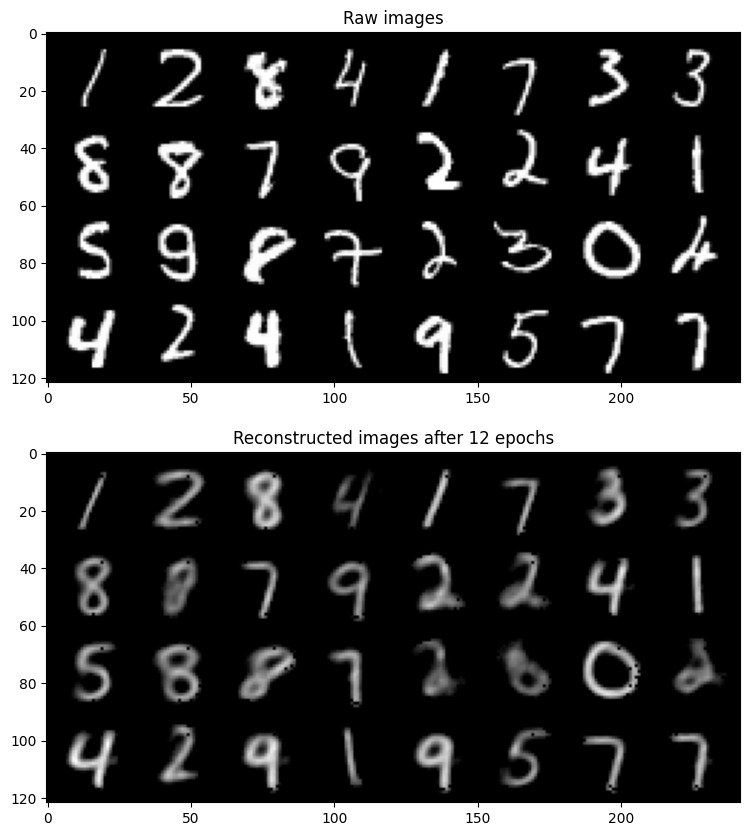

In [10]:
test_loss = reconstruct(test_loader,model,criterion,
                            N        = N,
                            show     = True,
                            figs     = '.',
                            n_images = 1,
                            prefix   = 'foo')

In [11]:
def plot_losses(Losses,
                lr                   = 0.001,
                encoder              = [],
                decoder              = [],
                encoder_nonlinearity = None,
                decoder_nonlinearity = None,
                N                    = 25,
                show                 = False,
                figs                 = './figs',
                prefix               = 'ae',
                test_loss            = 0):
    '''Plot curve of training losses'''
    fig = figure(figsize=(10,10))
    ax  = fig.subplots()
    ax.plot(Losses)
    ax.set_ylim(bottom=0)
    ax.set_title(f'Training Losses after {N} epochs')
    ax.set_ylabel('MSELoss')
    ax.text(0.95, 0.95, '\n'.join([f'lr = {lr}',
                                   f'encoder = {encoder}',
                                   f'decoder = {decoder}',
                                   f'encoder nonlinearity = {encoder_nonlinearity}',
                                   f'decoder nonlinearity = {decoder_nonlinearity}',
                                   f'test loss = {test_loss:.3f}'
                                   ]),
            transform           = ax.transAxes,
            fontsize            = 14,
            verticalalignment   = 'top',
            horizontalalignment = 'right',
            bbox                = dict(boxstyle  = 'round',
                                       facecolor = 'wheat',
                                       alpha     = 0.5))
    savefig(join(figs,f'{prefix}-losses'))
    if not show:
        close (fig)

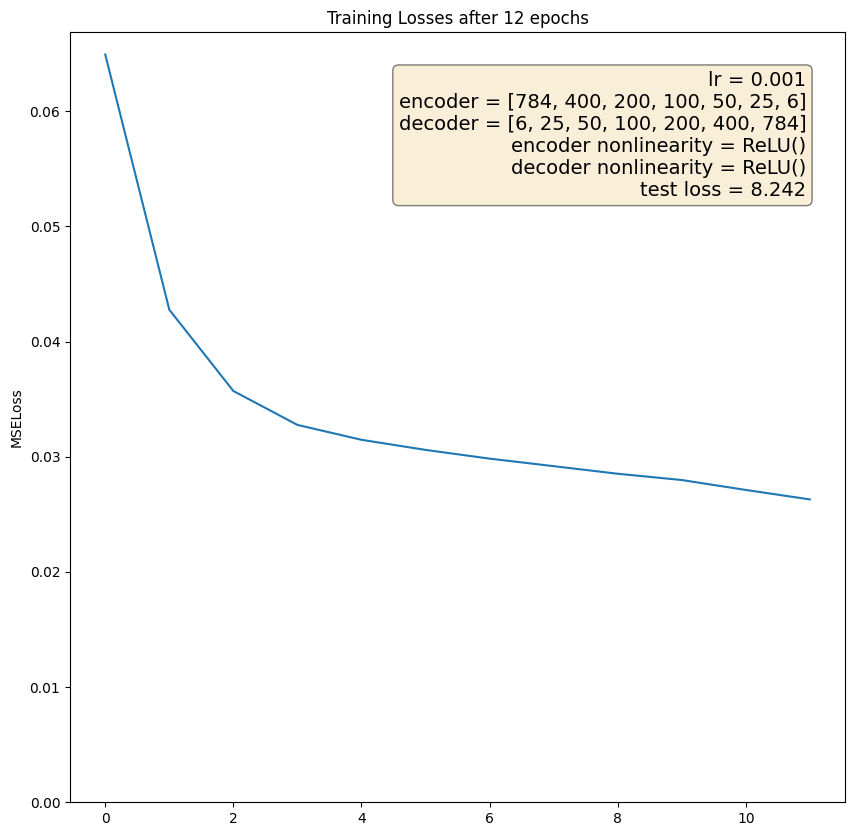

In [12]:
    plot_losses(Losses,
                lr                   = LR,
                encoder              = model.encoder_sizes,
                decoder              = model.decoder_sizes,
                encoder_nonlinearity = encoder_non_linearity,
                decoder_nonlinearity = decoder_non_linearity,
                N                    = N,
                show                 = True,
                figs                 = '.',
                prefix               = 'foo',
                test_loss            = test_loss)

In [14]:
def plot_encoding(loader,model,
                figs    = './figs',
                dev     = 'cpu',
                colours = [],
                show    = False,
                prefix  = 'ae'):
    '''Plot the encoding layer

       Since this is multi,dimensional, we will break it into 2D plots
    '''
    def extract_batch(batch_features, labels,index):
        '''Extract xs, ys, and colours for one batch'''

        dev = "cpu"
        batch_features = batch_features.view(-1, 784).to(dev)
        model.cpu()
        jj = model(batch_features)
        encoded        = model(batch_features).tolist()
        return list(zip(*([encoded[k][2*index] for k in range(len(labels))],
                          [encoded[k][2*index+1] for k in range(len(labels))],
                          [colours[labels.tolist()[k]] for k in range(len(labels))])))

    save_decode  = model.decode
    model.decode = False
    with no_grad():
        fig     = figure(figsize=(10,10))
        ax      = fig.subplots(nrows=2,ncols=2)
        for i in range(2):
            for j in range(2):
                if i==1 and j==1: break
                index    = 2*i + j
                if 2*index+1 < model.n_encoded():
                    xs,ys,cs = tuple(zip(*[xyc for batch_features, labels in loader for xyc in extract_batch(batch_features.cpu(), labels.cpu(),index)]))
                    ax[i][j].set_title(f'{2*index}-{2*index+1}')
                    ax[i][j].scatter(xs,ys,c=cs,s=1)

    ax[0][0].legend(handles=[Line2D([], [],
                                    color  = colours[k],
                                    marker = 's',
                                    ls     = '',
                                    label  = f'{k}') for k in range(10)])
    savefig(join(figs,f'{prefix}-encoding'))
    if not show:
        close (fig)

    model.decode = save_decode

# Plot encoded data

The encoding shows that the images for most digits are separated. It also suggests that the encoded data have been made to live in a 5-dimensional manifold instead of needing 6 dimensions.

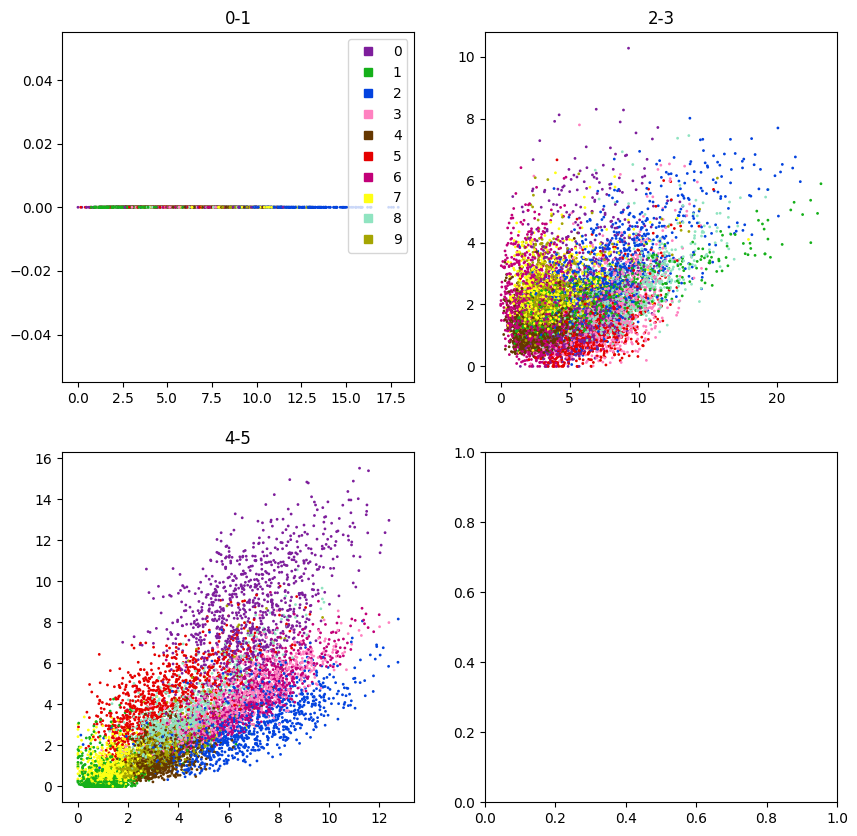

In [15]:
plot_encoding(test_loader,model,
                  show    = True,
                  colours = ['xkcd:purple',
                             'xkcd:green',
                             'xkcd:blue',
                             'xkcd:pink',
                             'xkcd:brown',
                             'xkcd:red',
                             'xkcd:magenta',
                             'xkcd:yellow',
                             'xkcd:light teal',
                             'xkcd:puke'],
                  figs    = '.',
                  prefix  = 'foo')